In [1]:
########################################################################################################################
#                                                          IMPORT                                                      #
########################################################################################################################
import torch
import sys
import os
import numpy as np
from singleVis.vis_models import vis_models
from singleVis.data import NormalDataProvider
from singleVis.projector import DVIProjector

from config import load_cfg
########################################################################################################################
#                                                     DVI PARAMETERS                                                   #
########################################################################################################################
"""DVI with semantic temporal edges"""
VIS_METHOD = "tdvi" # DeepVisualInsight


2024-05-15 10:31:06.142395: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-15 10:31:06.197472: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CONTENT_PATH = "/home/yangxl21/DVI_data/class_fromp"

In [3]:
########################################################################################################################
#                                                     LOAD PARAMETERS                                                  #
########################################################################################################################

sys.path.append(CONTENT_PATH)
config = load_cfg(os.path.join(CONTENT_PATH, "config", f"{VIS_METHOD}.yaml"))
print(config)

SETTING = config.SETTING
CLASSES = config.CLASSES
DATASET = config.DATASET
PREPROCESS = config.VISUALIZATION.PREPROCESS
GPU_ID = config.GPU
EPOCH_START = config.EPOCH_START
EPOCH_END = config.EPOCH_END
EPOCH_PERIOD = config.EPOCH_PERIOD
EPOCH_NAME = config.EPOCH_NAME

# Training parameter (subject model)
TRAINING_PARAMETER = config.TRAINING
NET = TRAINING_PARAMETER.NET
LEN = TRAINING_PARAMETER.train_num

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config.VISUALIZATION
SAVE_BATCH_SIZE = VISUALIZATION_PARAMETER.SAVE_BATCH_SIZE
LAMBDA = VISUALIZATION_PARAMETER.LAMBDA
B_N_EPOCHS = VISUALIZATION_PARAMETER.BOUNDARY.B_N_EPOCHS
L_BOUND = VISUALIZATION_PARAMETER.BOUNDARY.L_BOUND
ENCODER_DIMS = VISUALIZATION_PARAMETER.ENCODER_DIMS
DECODER_DIMS = VISUALIZATION_PARAMETER.DECODER_DIMS
S_N_EPOCHS = VISUALIZATION_PARAMETER.S_N_EPOCHS
T_N_EPOCHS = VISUALIZATION_PARAMETER.T_N_EPOCHS
N_NEIGHBORS = VISUALIZATION_PARAMETER.N_NEIGHBORS
PATIENT = VISUALIZATION_PARAMETER.PATIENT
MAX_EPOCH = VISUALIZATION_PARAMETER.MAX_EPOCH
VIS_MODEL = VISUALIZATION_PARAMETER.VIS_MODEL
METRIC = VISUALIZATION_PARAMETER.METRIC

VIS_MODEL_NAME = f"{VIS_METHOD}"
EVALUATION_NAME = f"evaluation_{VIS_MODEL_NAME}"

# Define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))

########################################################################################################################
#                                                    TRAINING SETTING                                                  #
########################################################################################################################
# Define data_provider
data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, device=DEVICE, classes=CLASSES, epoch_name=EPOCH_NAME, verbose=1)
# Define visualization models
model = vis_models[VIS_MODEL](ENCODER_DIMS, DECODER_DIMS)

# Define Projector
projector = DVIProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, epoch_name=EPOCH_NAME, device=DEVICE)


CLASSES: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
DATASET: MNIST
EPOCH_END: 5
EPOCH_NAME: Epoch
EPOCH_PERIOD: 1
EPOCH_START: 1
GPU: 4
SETTING: normal
TRAINING:
  NET: cl_classifier
  test_num: 10000
  train_num: 60000
VISUALIZATION:
  ALPHA: 0.0
  BETA: 0.1
  BOUNDARY:
    B_N_EPOCHS: 0
    L_BOUND: 0.4
  DECODER_DIMS: [2, 200, 400]
  Delay: 1
  Delay_time: 32
  ENCODER_DIMS: [400, 200, 2]
  INIT_NUM: 300
  LAMBDA: 1.0
  LAMBDA1: 1.0
  LAMBDA2: 0.3
  MAX_EPOCH: 20
  METRIC: euclidean
  N_NEIGHBORS: 15
  PATIENT: 3
  PREPROCESS: 1
  RESOLUTION: 300
  SAVE_BATCH_SIZE: 1000
  S_N_EPOCHS: 3
  T_N_EPOCHS: 2
  VIS_MODEL: cnAE
Finish initialization...


In [4]:
########################################################################################################################
#                                                      VISUALIZATION                                                   #
########################################################################################################################
from singleVis.visualizer import visualizer

vis = visualizer(data_provider, projector, 200)
save_dir = os.path.join(data_provider.content_path, "img")
os.makedirs(save_dir, exist_ok=True)
    

In [6]:
# fromp domain
for epoch in range(1, 6, 1):
    data = data_provider.train_representation(epoch=epoch)
    labels = data_provider.train_labels(epoch=epoch) % 2

    pred = data_provider.get_pred(epoch, data)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(epoch, data, pred, labels, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 4094.86it/s]

Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4357.40it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 3660.48it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 3120.43it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 2540.21it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 3197.00it/s]


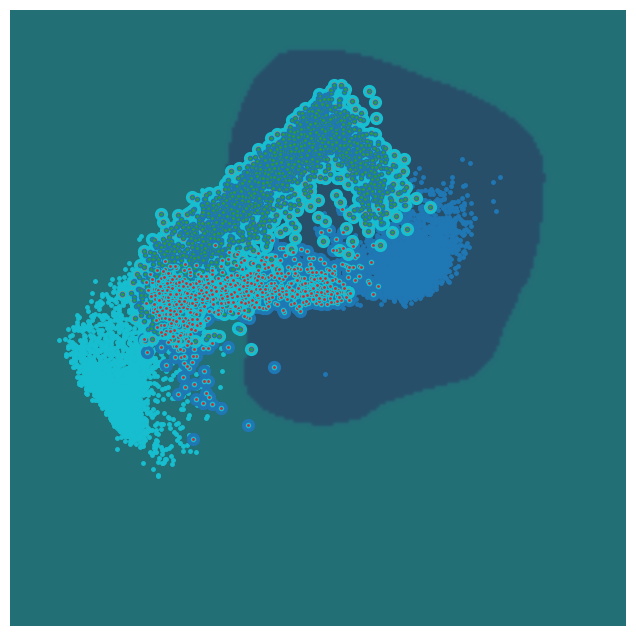

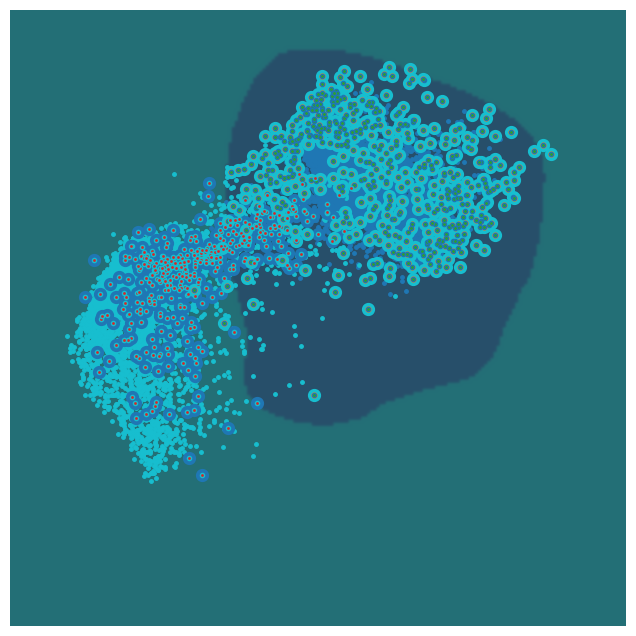

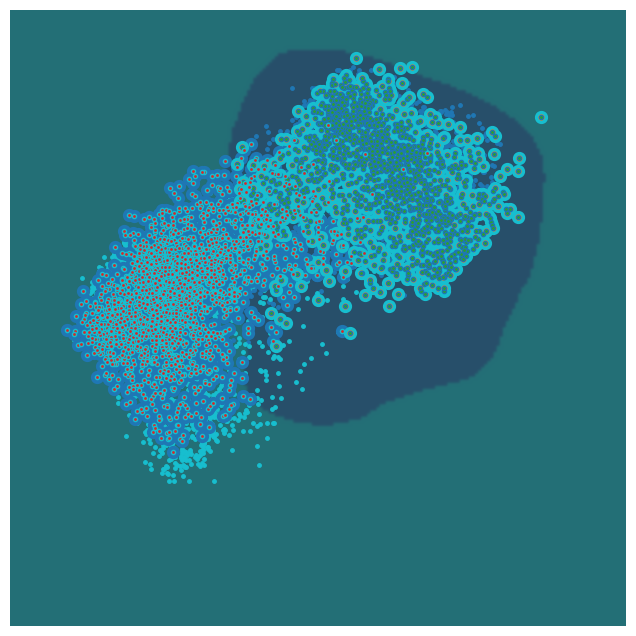

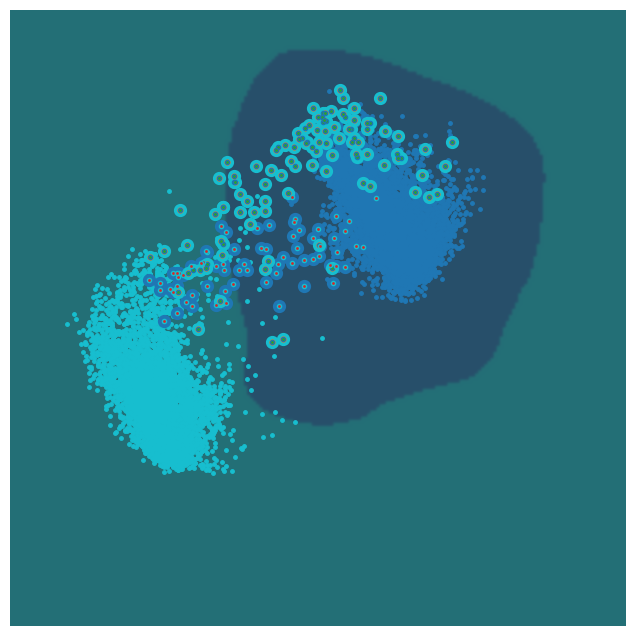

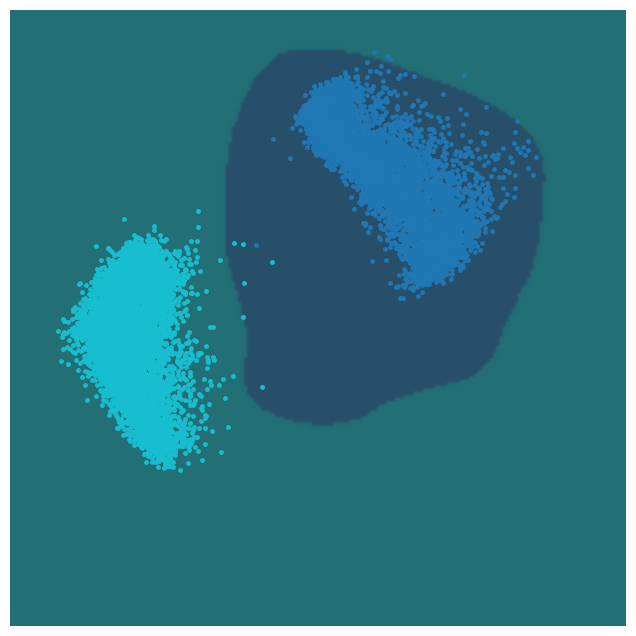

In [6]:
# fromp domain
import json
train_data_loc = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 5), "train_data.npy")
data = np.load(train_data_loc)
training_data_loc = os.path.join(data_provider.content_path, "Training_data", "training_dataset_label.pth")
labels = torch.load(training_data_loc, map_location="cpu").numpy()
for epoch in range(1, 6, 1):
    index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, epoch), "index.json")
    with open(index_file, 'r') as f:
        index = json.load(f)

    data_ = data[index]
    labels_ = labels[index] % 2

    pred = data_provider.get_pred(5, data_)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(5, data_, pred, labels_, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 105.02it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 3136.77it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 2876.42it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 2929.86it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 2913.05it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 2761.95it/s]


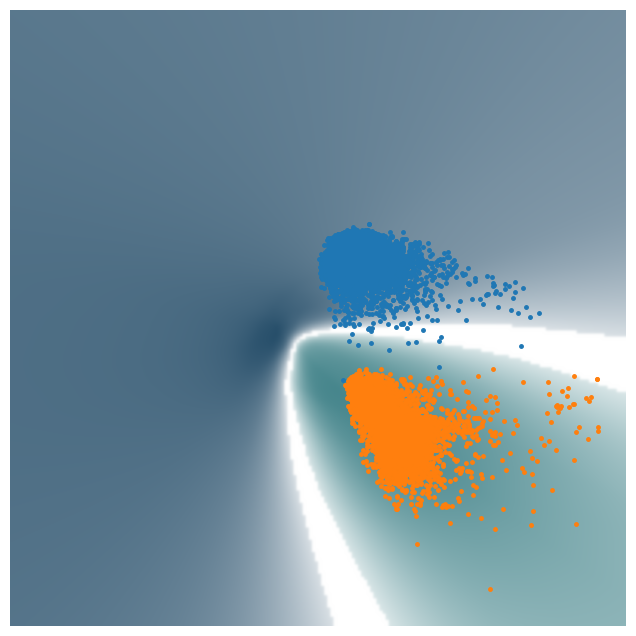

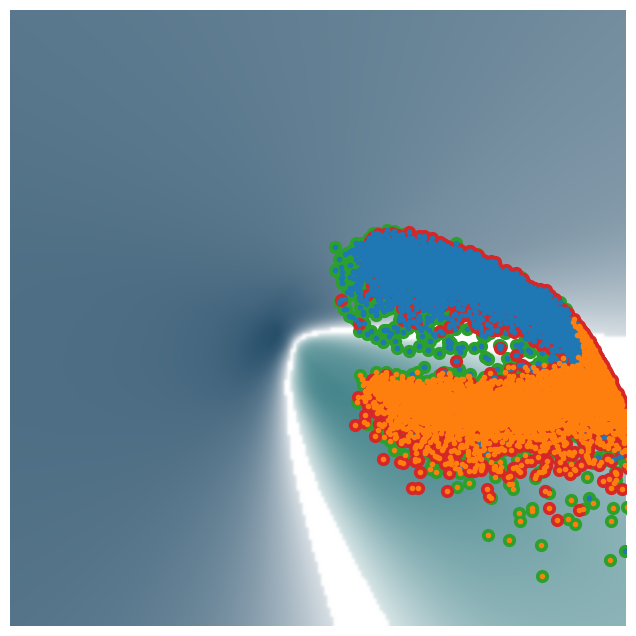

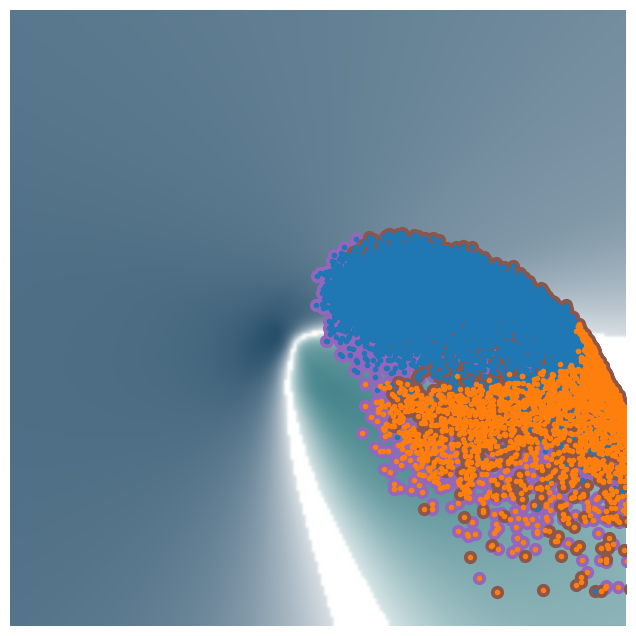

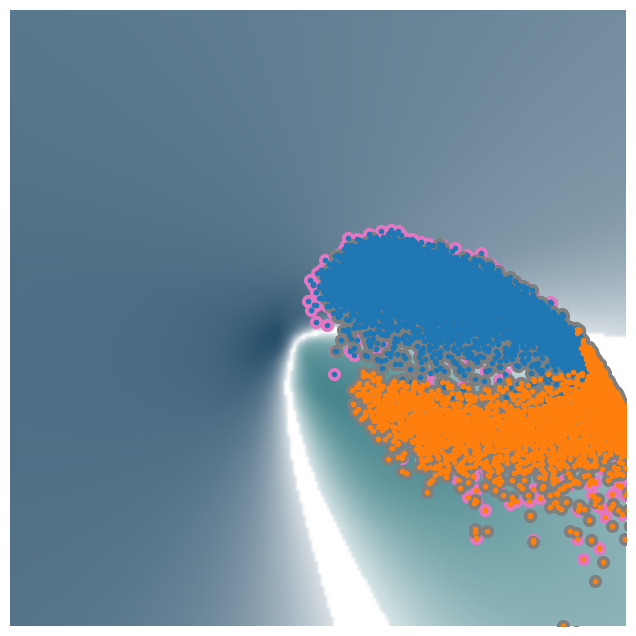

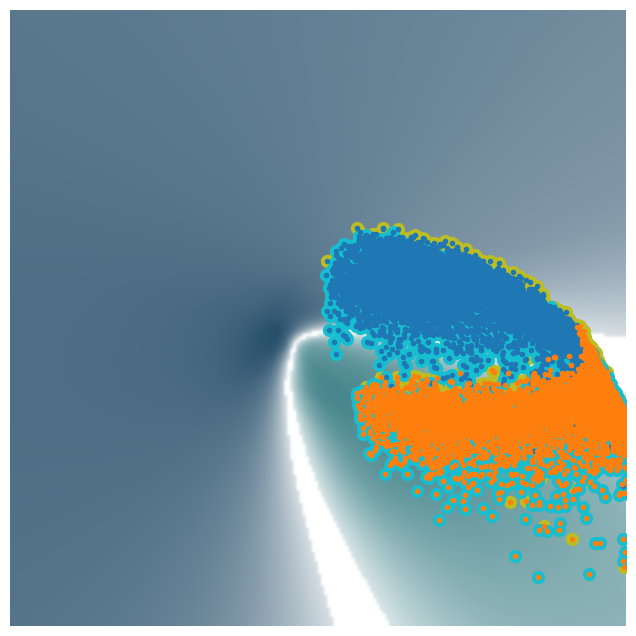

In [5]:
# class transfer fromp
import json
train_data_loc = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 1), "train_data.npy")
data = np.load(train_data_loc)
training_data_loc = os.path.join(data_provider.content_path, "Training_data", "training_dataset_label.pth")
labels = torch.load(training_data_loc, map_location="cpu").numpy()
for epoch in range(1, 6, 1):
    index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, epoch), "index.json")
    with open(index_file, 'r') as f:
        index = json.load(f)

    data_ = data[index]
    labels_ = labels[index]

    pred = data_provider.get_pred(1, data_)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(1, data_, pred, labels_, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 110.24it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 3210.51it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 3080.65it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 3220.02it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 2827.62it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 2857.45it/s]


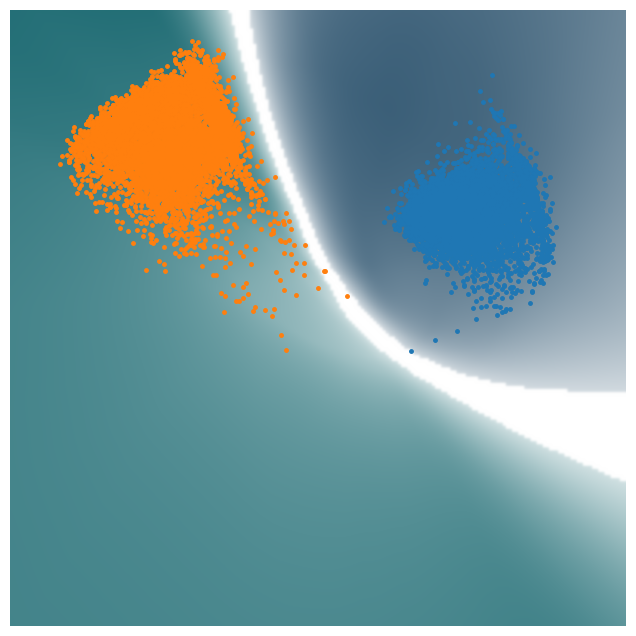

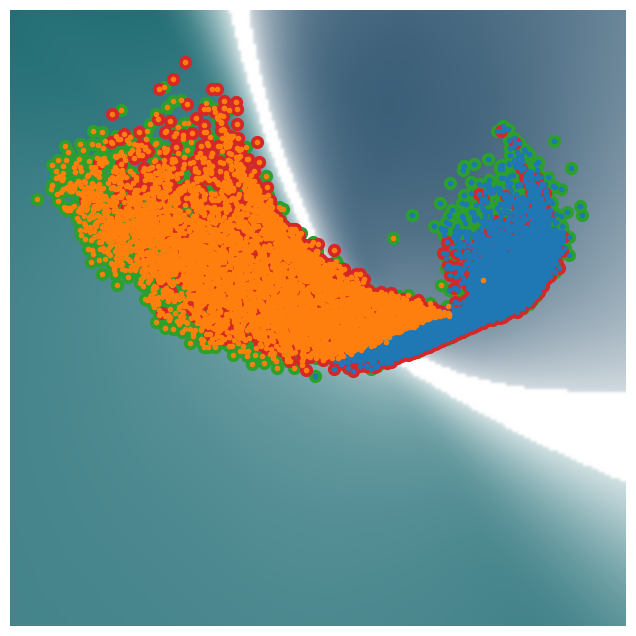

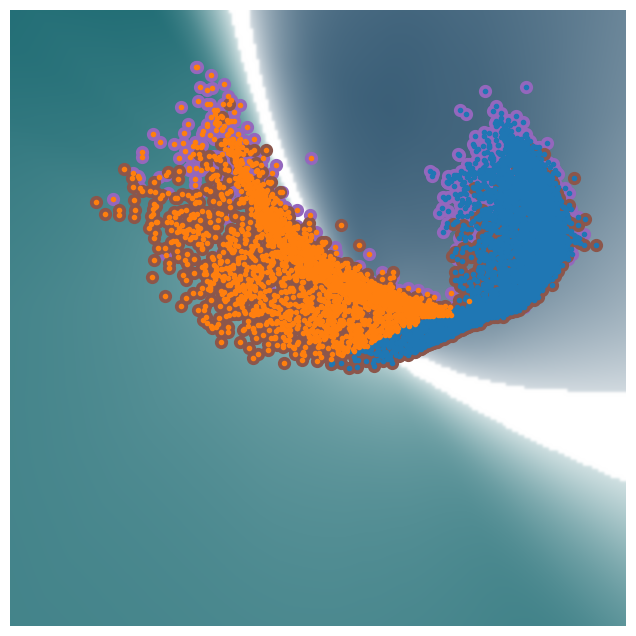

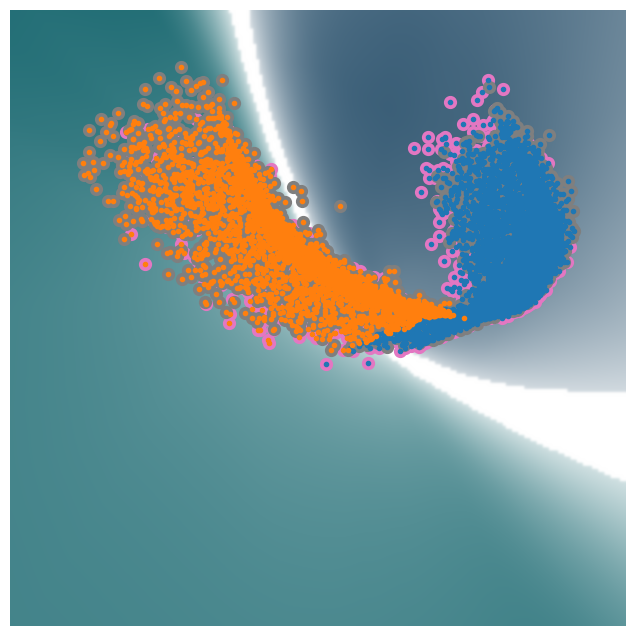

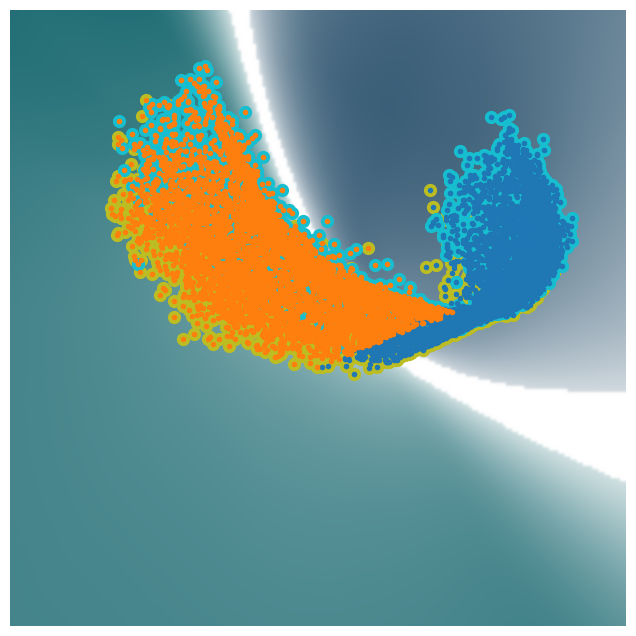

In [5]:
# class transfer
import json
train_data_loc = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 1), "train_data.npy")
data = np.load(train_data_loc)
training_data_loc = os.path.join(data_provider.content_path, "Training_data", "training_dataset_label.pth")
labels = torch.load(training_data_loc, map_location="cpu").numpy()
for epoch in range(1, 6, 1):
    index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, epoch), "index.json")
    with open(index_file, 'r') as f:
        index = json.load(f)

    data_ = data[index]
    labels_ = labels[index]

    pred = data_provider.get_pred(1, data_)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(1, data_, pred, labels_, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 3684.76it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4409.09it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 3989.69it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4385.38it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4353.52it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 5565.32it/s]


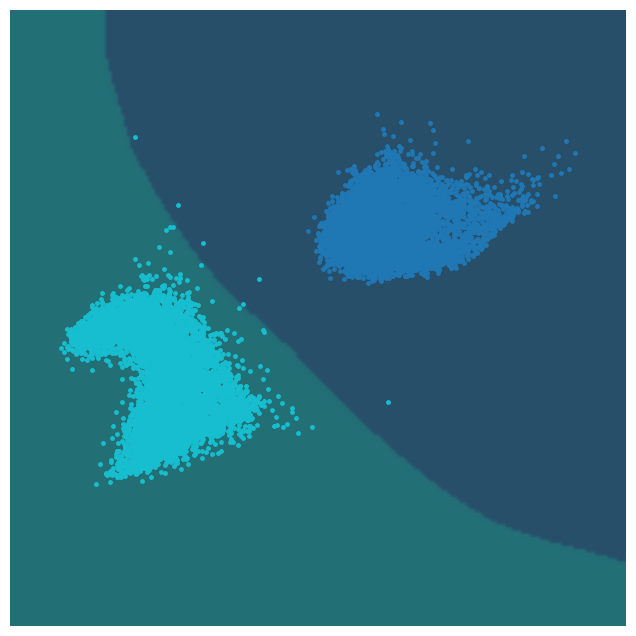

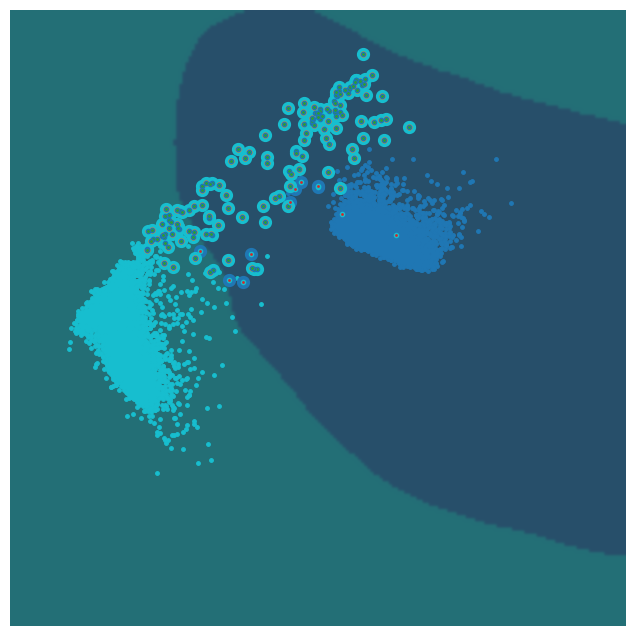

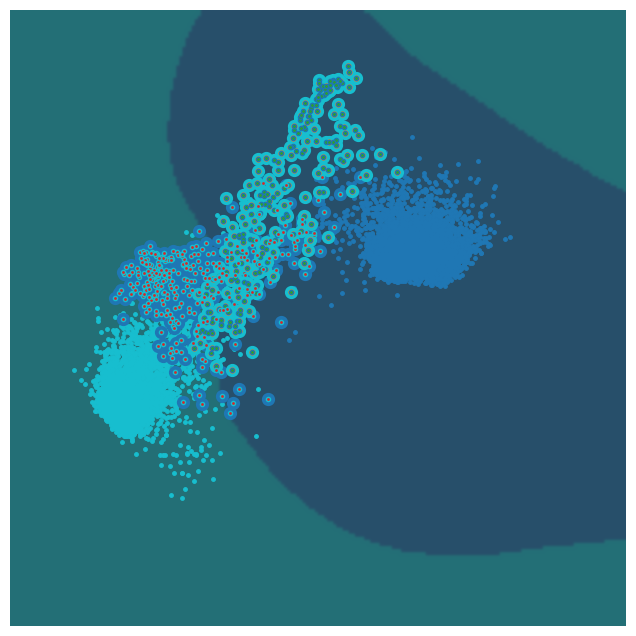

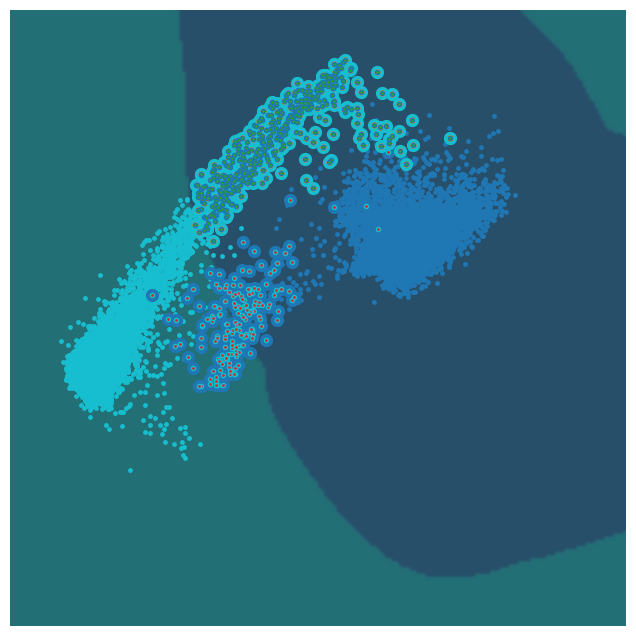

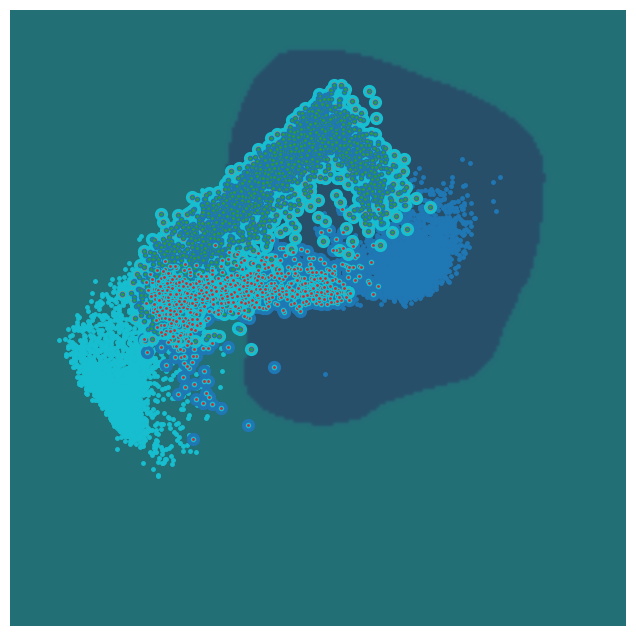

In [7]:
# fromp
index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 1), "index.json")
with open(index_file, 'r') as f:
    index = json.load(f)
for epoch in range(1, 6, 1):
    train_data_loc = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, epoch), "train_data.npy")
    data = np.load(train_data_loc)
    training_data_loc = os.path.join(data_provider.content_path, "Training_data", "training_dataset_label.pth")
    labels = torch.load(training_data_loc, map_location="cpu").numpy()
    

    data_ = data[index]
    labels_ = labels[index] % 2

    pred = data_provider.get_pred(epoch, data_)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(epoch, data_, pred, labels_, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 104.54it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 2056.75it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 3801.48it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 3934.62it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 3666.88it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 5502.53it/s]


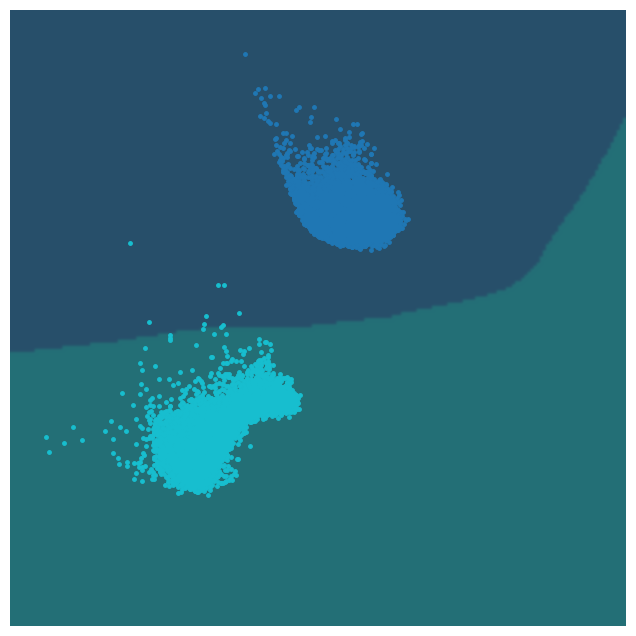

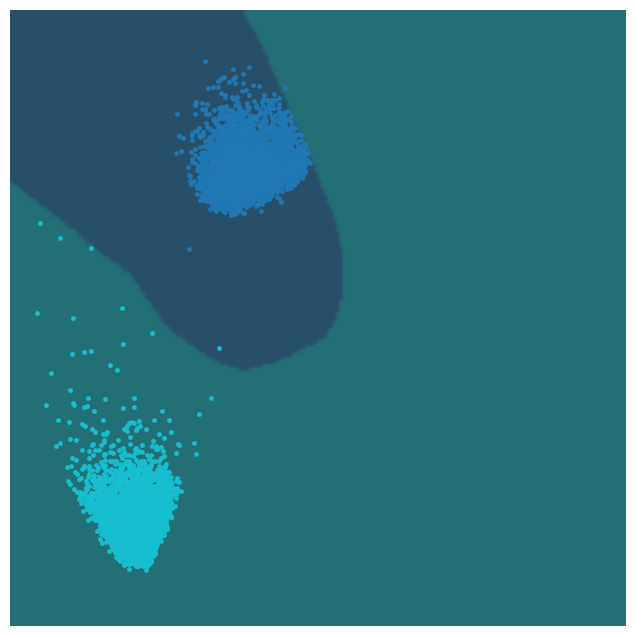

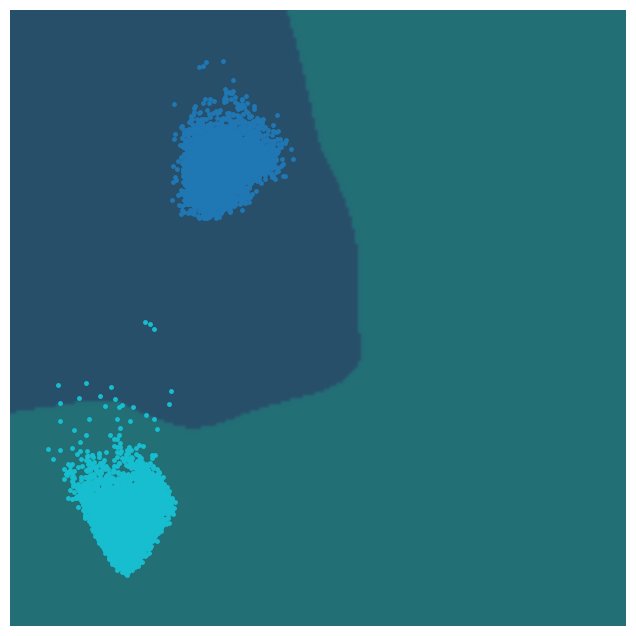

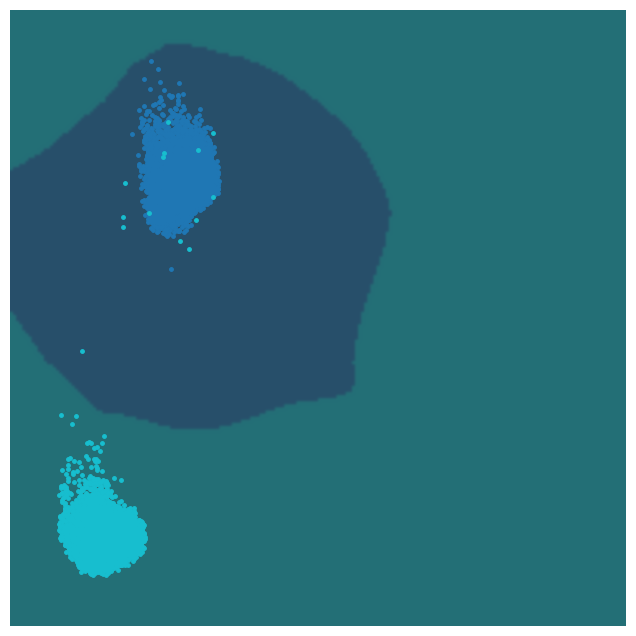

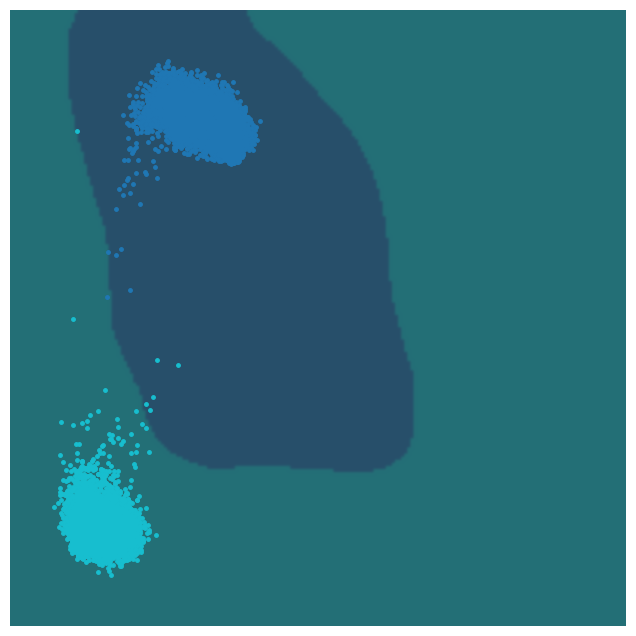

In [5]:
# replay
for epoch in range(1, 6, 1):
    data = data_provider.train_representation(epoch=epoch)
    labels = data_provider.train_labels(epoch=epoch) % 2

    pred = data_provider.get_pred(epoch, data)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(epoch, data, pred, labels, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 3667.72it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4475.63it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 3862.16it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4521.81it/s]


Computing decision regions ...


100%|██████████| 6/6 [00:00<00:00, 4068.85it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 5700.33it/s]


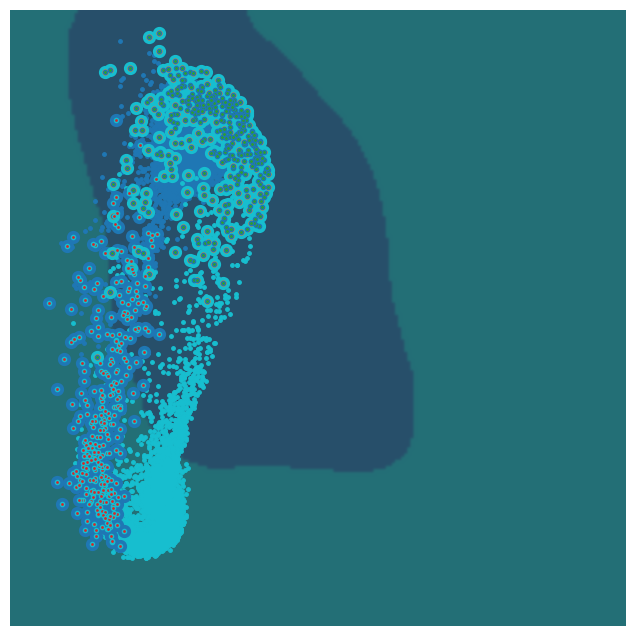

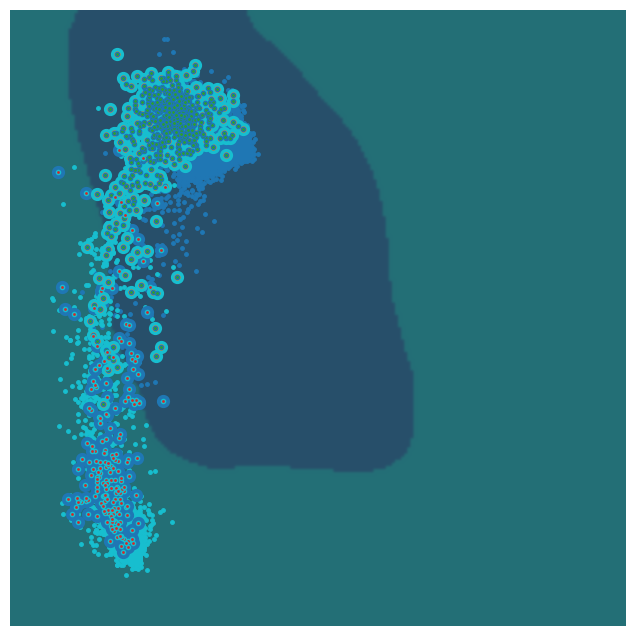

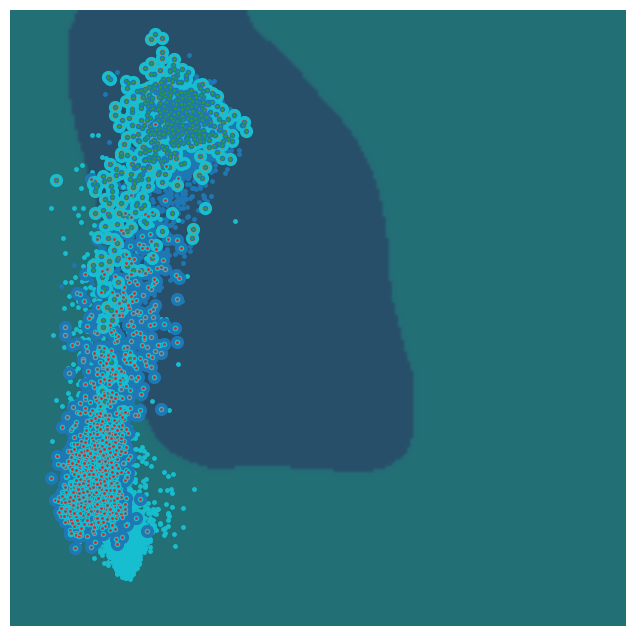

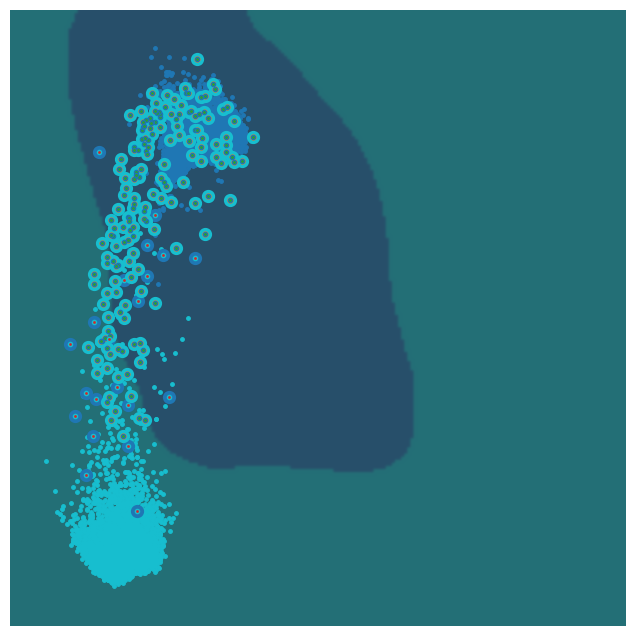

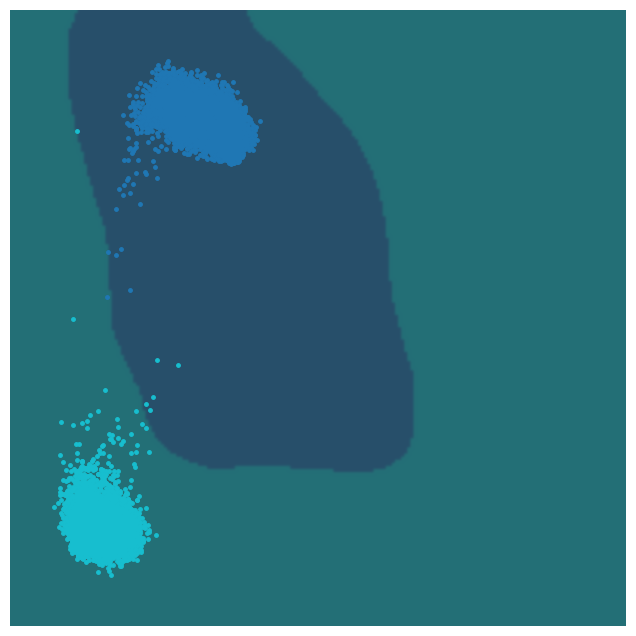

In [8]:
# replay
import json
train_data_loc = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 5), "train_data.npy")
data = np.load(train_data_loc)
training_data_loc = os.path.join(data_provider.content_path, "Training_data", "training_dataset_label.pth")
labels = torch.load(training_data_loc, map_location="cpu").numpy()
for epoch in range(1, 6, 1):
    index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, epoch), "index.json")
    with open(index_file, 'r') as f:
        index = json.load(f)

    data_ = data[index]
    labels_ = labels[index] % 2

    pred = data_provider.get_pred(5, data_)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(5, data_, pred, labels_, filename="vis")

100%|██████████| 7/7 [00:00<00:00, 4138.73it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4336.80it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4133.48it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4566.12it/s]


Computing decision regions ...


100%|██████████| 7/7 [00:00<00:00, 4190.11it/s]


Computing decision regions ...


100%|██████████| 20/20 [00:00<00:00, 5553.16it/s]


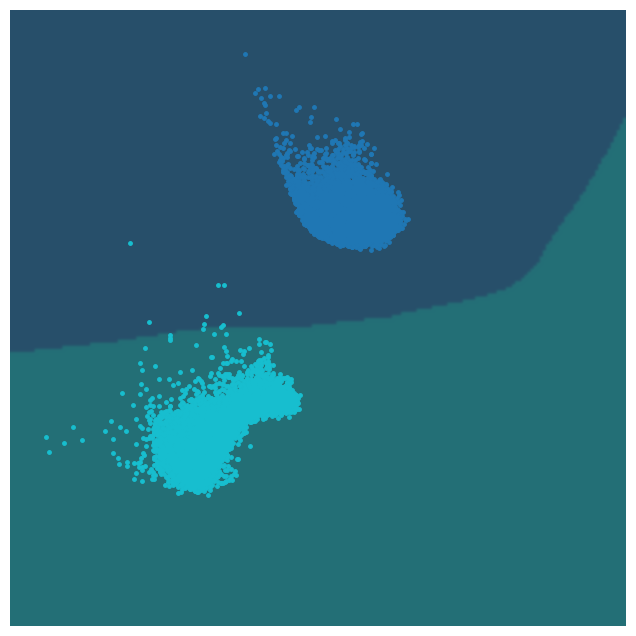

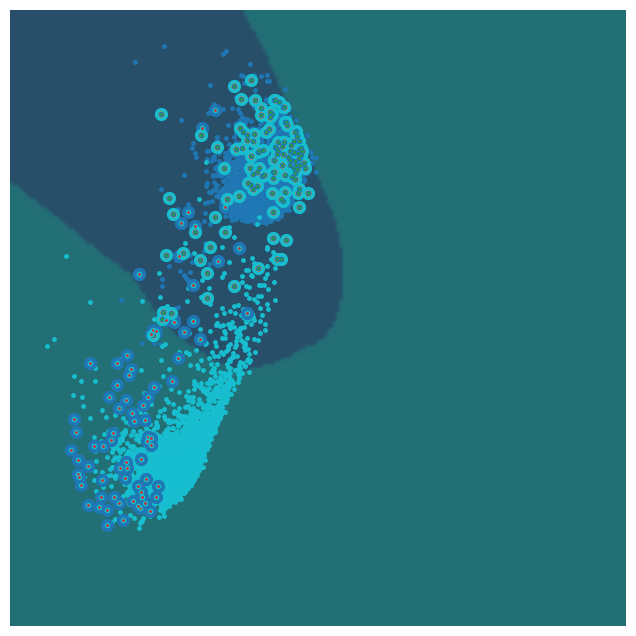

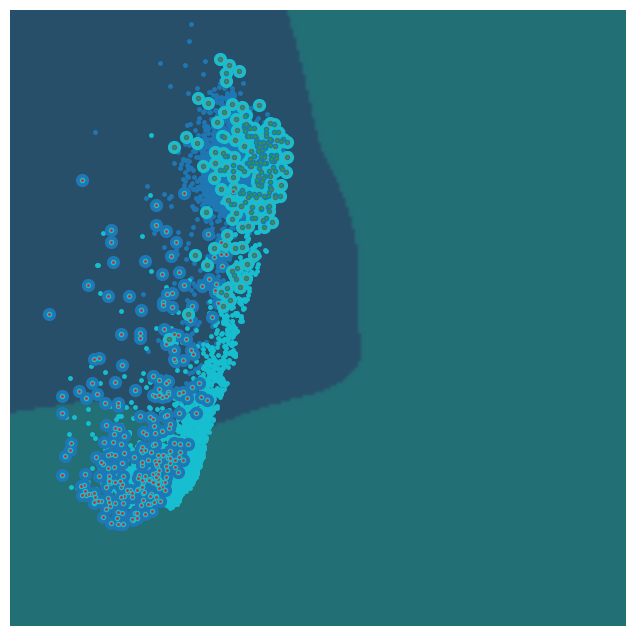

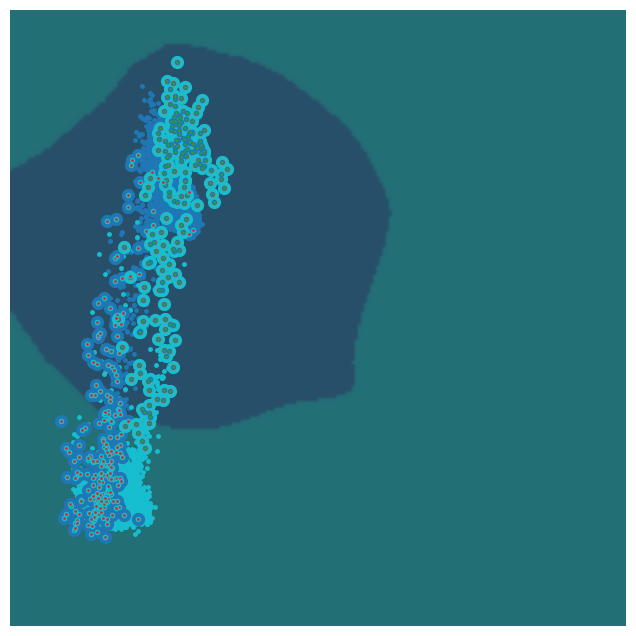

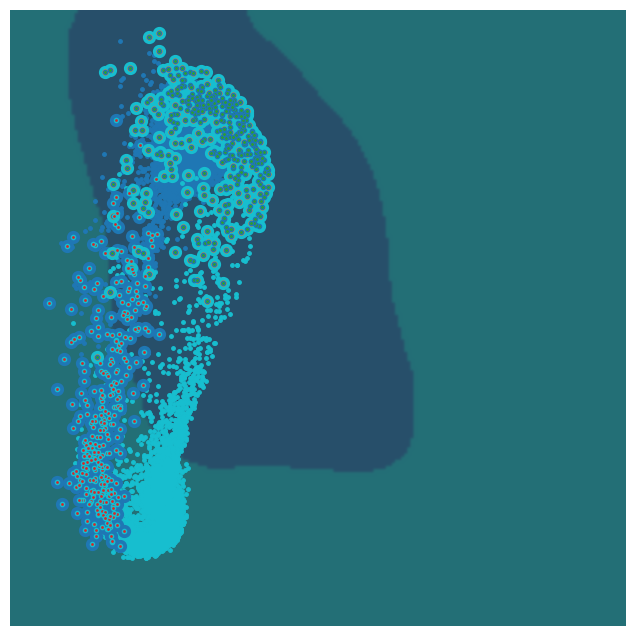

In [7]:
# replay
import json
index_file = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, 1), "index.json")
with open(index_file, 'r') as f:
    index = json.load(f)
for epoch in range(1, 6, 1):
    train_data_loc = os.path.join(data_provider.model_path, "{}_{:d}".format(data_provider.epoch_name, epoch), "train_data.npy")
    data = np.load(train_data_loc)
    training_data_loc = os.path.join(data_provider.content_path, "Training_data", "training_dataset_label.pth")
    labels = torch.load(training_data_loc, map_location="cpu").numpy()
    

    data_ = data[index]
    labels_ = labels[index] % 2

    pred = data_provider.get_pred(epoch, data_)
    pred = np.argmax(pred, axis=1)
    vis.savefig_cus(epoch, data_, pred, labels_, filename="vis")